In [2]:
!nvidia-smi

Wed Jan 11 10:40:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import data
import numpy as np

In [4]:
BATCH_SIZE = 16
IMG_SIZE = (224, 224)

train_dir = '/content/drive/MyDrive/data_si/train'
valid_dir = '/content/drive/MyDrive/data_si/val'
test_dir = '/content/drive/MyDrive/data_si/test'

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 1868 files belonging to 36 classes.


In [5]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(valid_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 467 files belonging to 36 classes.


In [6]:
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                           shuffle=True,
                                                           batch_size=BATCH_SIZE,
                                                           image_size=IMG_SIZE)

Found 180 files belonging to 36 classes.


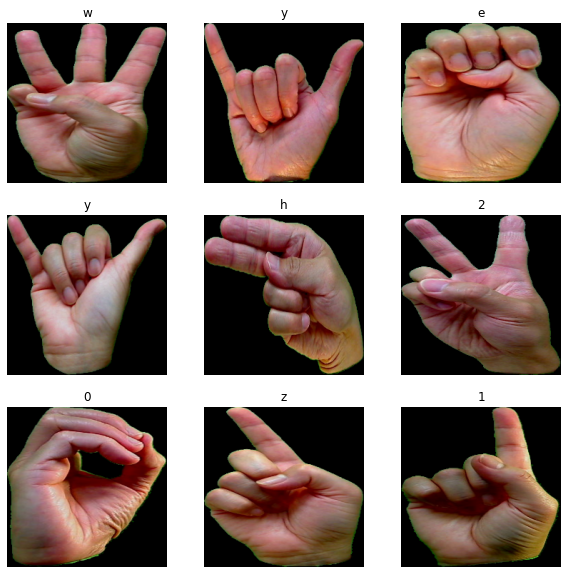

In [7]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [9]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.1),
  tf.keras.layers.RandomContrast(factor=0.7),
  tf.keras.layers.RandomBrightness(factor=0.7)
])

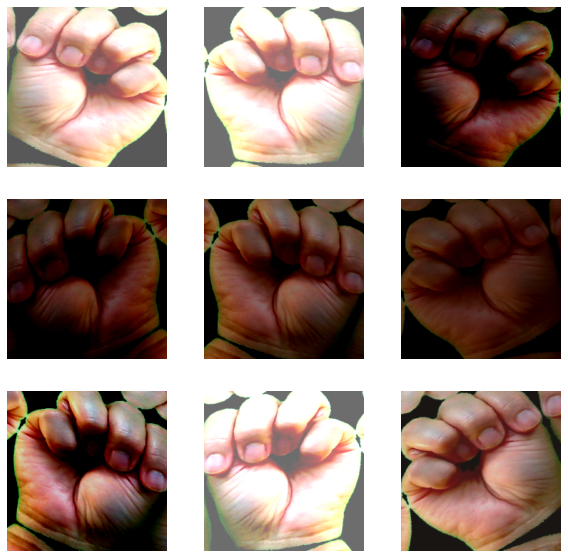

In [10]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [11]:
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

In [12]:
rescale = tf.keras.layers.Rescaling(1./255)

In [13]:
# Create the base model from the pre-trained model EfficientNet
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.EfficientNetB7(input_shape=IMG_SHAPE,
                                                  include_top=False,
                                                  weights='imagenet')

258076736/258076736 [==============================] - 1s 0us/step


In [14]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 7, 7, 2560)


In [15]:
base_model.trainable = False

In [16]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "efficientnetb7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling_1[0][0]']            
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['normalization[0][0

In [17]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 2560)


In [18]:
prediction_layer = tf.keras.layers.Dense(36)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(16, 36)


In [19]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [20]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetb7 (Functional)  (None, 7, 7, 2560)       64097687  
                                                                 
 global_average_pooling2d (G  (None, 2560)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2560)              0         
                                                                 
 dense (Dense)               (None, 36)                92196     
                                                             

In [22]:
len(model.trainable_variables)

2

In [23]:
initial_epochs = 20

# loss0, accuracy0 = model.evaluate(validation_dataset)

In [24]:
# print("initial loss: {:.2f}".format(loss0))
# print("initial accuracy: {:.2f}".format(accuracy0))

In [25]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/20


117/117 [==============================] - 439s 4s/step - loss: 3.5066 - accuracy: 0.0648 - val_loss: 3.3552 - val_accuracy: 0.2034
Epoch 2/20
117/117 [==============================] - 44s 375ms/step - loss: 3.2828 - accuracy: 0.1734 - val_loss: 3.1565 - val_accuracy: 0.3233
Epoch 3/20
117/117 [==============================] - 43s 358ms/step - loss: 3.0990 - accuracy: 0.2527 - val_loss: 2.9904 - val_accuracy: 0.3769
Epoch 4/20
117/117 [==============================] - 42s 358ms/step - loss: 2.9258 - accuracy: 0.3201 - val_loss: 2.8417 - val_accuracy: 0.4154
Epoch 5/20
117/117 [==============================] - 43s 362ms/step - loss: 2.7999 - accuracy: 0.3715 - val_loss: 2.7169 - val_accuracy: 0.4647
Epoch 6/20
117/117 [==============================] - 44s 375ms/step - loss: 2.6876 - accuracy: 0.3945 - val_loss: 2.6106 - val_accuracy: 0.4818
Epoch 7/20
117/117 [==============================] - 43s 361ms/step - loss: 2.5757 - accuracy: 0.4331 - val_loss: 2.5171 - val_accuracy: 0.513

27 mins to run epoch 1 to 20

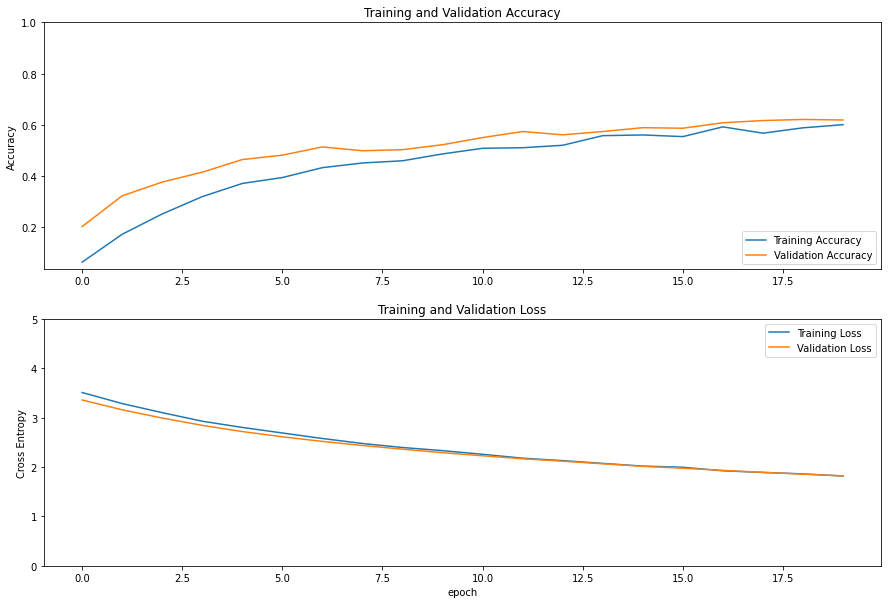

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.savefig('acc_loss_efficientnetB7_si_before.png', dpi=300)
plt.show()

In [27]:
base_model.trainable = True

In [28]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# # Fine-tune from this layer onwards
# fine_tune_at = 100

# # Freeze all the layers before the `fine_tune_at` layer
# for layer in base_model.layers[:fine_tune_at]:
#   layer.trainable = False

Number of layers in the base model:  814


In [29]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetb7 (Functional)  (None, 7, 7, 2560)       64097687  
                                                                 
 global_average_pooling2d (G  (None, 2560)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2560)              0         
                                                                 
 dense (Dense)               (None, 36)                92196     
                                                             

In [31]:
len(model.trainable_variables)

711

In [32]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 20/40


117/117 [==============================] - 196s 1s/step - loss: 1.0334 - accuracy: 0.7200 - val_loss: 0.6070 - val_accuracy: 0.8223
Epoch 21/40
117/117 [==============================] - 139s 1s/step - loss: 0.6644 - accuracy: 0.8089 - val_loss: 0.4141 - val_accuracy: 0.8758
Epoch 22/40
117/117 [==============================] - 138s 1s/step - loss: 0.4918 - accuracy: 0.8464 - val_loss: 0.3239 - val_accuracy: 0.8994
Epoch 23/40
117/117 [==============================] - 140s 1s/step - loss: 0.4123 - accuracy: 0.8699 - val_loss: 0.2622 - val_accuracy: 0.9101
Epoch 24/40
117/117 [==============================] - 140s 1s/step - loss: 0.3434 - accuracy: 0.8892 - val_loss: 0.2082 - val_accuracy: 0.9507
Epoch 25/40
117/117 [==============================] - 138s 1s/step - loss: 0.3130 - accuracy: 0.8999 - val_loss: 0.1610 - val_accuracy: 0.9486
Epoch 26/40
117/117 [==============================] - 139s 1s/step - loss: 0.2885 - accuracy: 0.9095 - val_loss: 0.1536 - val_accuracy: 0.9529
Epoc

50 mins to run epoch 20 to 40

In [33]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

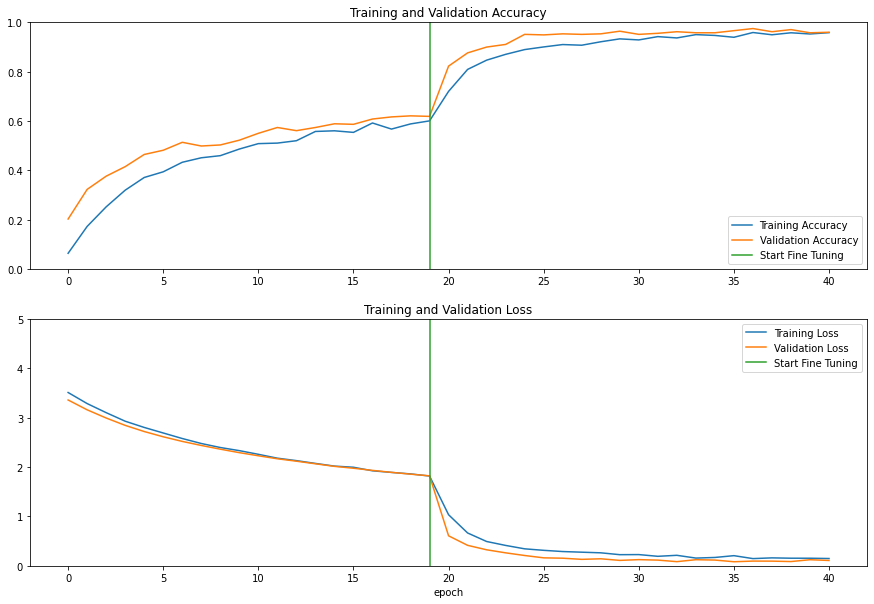

In [34]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 5])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.savefig('acc_loss_efficientnetB7_si_after.png', dpi=300)
plt.show()

In [35]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy: {:.4f}' .format(accuracy))

12/12 [==============================] - 35s 775ms/step - loss: 0.4020 - accuracy: 0.9000
Test accuracy: 0.9000


Model  | SI Accuracy
-------------------|------------------
ResNet      | 82.22
MobileNetV2       | 
VGG19 | 
EfficientNetB5 | 84.44
EfficientNetB7 | 90.00


In [36]:
img_height = 224
img_width = 224

img = tf.keras.utils.load_img(
    '/content/drive/MyDrive/test_pictures/m.jpeg', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 6s 6s/step
This image most likely belongs to i with a 65.40 percent confidence.


In [37]:
model.save('transfer_learning_efficientnetb7_si.h5')

Time Taken for Signer Independent

EfficientNetB5 - 

EfficientNetB7 - 27 + 50 = 77 mins (1h 17m)

In [38]:
# from google.colab import drive
# drive.mount('/content/drive')